# Workflows Video Creatifs

**Module :** 04-Applications  
**Niveau :** Applications  
**Technologies :** moviepy, diffusers, Pillow, numpy, scipy  
**Duree estimee :** 50 minutes  
**VRAM :** ~16 GB (optionnel, certaines sections CPU uniquement)  

## Objectifs d'Apprentissage

- [ ] Appliquer un transfert de style sur des frames video (approche conceptuelle avec diffusers img2img)
- [ ] Creer un clip musical avec decoupes synchronisees sur le rythme
- [ ] Produire un effet stop-motion a partir d'une video (echantillonnage et traitement de frames)
- [ ] Appliquer un color grading et des effets cinematographiques
- [ ] Composer des grilles et collages video
- [ ] Creer des animations de texte creatives

## Prerequis

- Python 3.10+
- Notebooks 01-1 a 03-3 (fondations, techniques avancees, orchestration)
- Notebook 04-1 (generation de videos educatives)
- Packages : `moviepy`, `Pillow`, `numpy`, `scipy`, `matplotlib`
- Optionnel : `diffusers`, `torch` pour le transfert de style IA

**Navigation** : [<< 04-1 Educational Video](04-1-Educational-Video-Generation.ipynb) | [04-3 Sora API >>](04-3-Sora-API-Cloud-Video.ipynb)

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres video
video_width = 640                  # Largeur video de travail
video_height = 480                 # Hauteur video de travail
video_fps = 24                     # FPS
video_duration = 6                 # Duree video source (secondes)
output_format = "mp4"              # Format de sortie

# Options creatives
enable_style_transfer = True       # Activer le transfert de style
enable_music_video = True          # Activer la creation music video
enable_stop_motion = True          # Activer l'effet stop-motion
enable_color_grading = True        # Activer le color grading
enable_text_animation = True       # Activer les animations de texte
save_results = True                # Sauvegarder les resultats

In [2]:
# Parameters
notebook_mode = "batch"
skip_widgets = True


In [3]:
# Setup environnement et imports
import os
import sys
import json
import time
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import logging

warnings.filterwarnings('ignore', category=DeprecationWarning)

# Resolution GENAI_ROOT
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.video_helpers import get_video_info, extract_frames, display_frame_grid
        print("Helpers video importes")
    except ImportError as e:
        print(f"Helpers video non disponibles ({e}) - mode autonome")

# Repertoire de sortie
OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'video'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuration logging
logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('creative_video')

print(f"Workflows Video Creatifs")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Video : {video_width}x{video_height} @ {video_fps}fps, {video_duration}s")
print(f"Sortie : {OUTPUT_DIR}")

Workflows Video Creatifs
Date : 2026-02-19 10:30:49
Mode : batch
Video : 640x480 @ 24fps, 6s
Sortie : D:\outputs\video


In [4]:
# Chargement .env et verification des dependances
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")

# Verification des dependances
print("\n--- VERIFICATION DES DEPENDANCES ---")
print("=" * 40)

dependencies = {}

try:
    import moviepy.editor as mpy
    dependencies['moviepy'] = True
    print(f"moviepy : disponible")
except ImportError:
    dependencies['moviepy'] = False
    print(f"moviepy : NON INSTALLE (pip install moviepy)")

try:
    import imageio
    dependencies['imageio'] = True
    print(f"imageio : disponible")
except ImportError:
    dependencies['imageio'] = False
    print(f"imageio : NON INSTALLE (pip install imageio imageio-ffmpeg)")

try:
    from scipy import signal, ndimage
    dependencies['scipy'] = True
    print(f"scipy : disponible")
except ImportError:
    dependencies['scipy'] = False
    print(f"scipy : NON INSTALLE (pip install scipy)")

try:
    import diffusers
    import torch
    dependencies['diffusers'] = True
    gpu_available = torch.cuda.is_available()
    print(f"diffusers : disponible (GPU: {gpu_available})")
except ImportError:
    dependencies['diffusers'] = False
    print(f"diffusers : NON INSTALLE (optionnel)")

available_count = sum(dependencies.values())
total_count = len(dependencies)
print(f"\nDependances disponibles : {available_count}/{total_count}")

# Generation d'une video source de travail
print("\n--- GENERATION VIDEO SOURCE ---")
print("=" * 40)

n_frames = video_fps * video_duration
source_frames = []
for i in range(n_frames):
    t = i / n_frames
    # Scene avec mouvement : gradient + cercle anime
    img = Image.new('RGB', (video_width, video_height))
    pixels = np.zeros((video_height, video_width, 3), dtype=np.uint8)
    
    # Gradient de fond anime
    for y in range(video_height):
        r = int(50 + 100 * (y / video_height) + 50 * np.sin(2 * np.pi * t))
        g = int(30 + 80 * (1 - y / video_height))
        b = int(100 + 100 * np.cos(2 * np.pi * t))
        pixels[y, :] = [min(255, max(0, r)), min(255, max(0, g)), min(255, max(0, b))]
    
    img = Image.fromarray(pixels)
    draw = ImageDraw.Draw(img)
    
    # Objets animes
    cx = int(video_width * 0.5 + video_width * 0.3 * np.cos(2 * np.pi * t))
    cy = int(video_height * 0.4 + video_height * 0.2 * np.sin(4 * np.pi * t))
    draw.ellipse([cx - 30, cy - 30, cx + 30, cy + 30], fill=(255, 200, 50))
    
    # Deuxieme objet
    cx2 = int(video_width * 0.3 + video_width * 0.15 * np.sin(3 * np.pi * t))
    cy2 = int(video_height * 0.6)
    draw.rectangle([cx2 - 20, cy2 - 20, cx2 + 20, cy2 + 20], fill=(100, 200, 255))
    
    source_frames.append(np.array(img))

print(f"Video source generee : {len(source_frames)} frames")
print(f"Resolution : {video_width}x{video_height} @ {video_fps}fps")

Aucun fichier .env trouve

--- VERIFICATION DES DEPENDANCES ---
moviepy : NON INSTALLE (pip install moviepy)
imageio : disponible


scipy : disponible


diffusers : disponible (GPU: False)

Dependances disponibles : 3/4

--- GENERATION VIDEO SOURCE ---


Video source generee : 144 frames
Resolution : 640x480 @ 24fps


## Section 1 : Transfert de style video

Le transfert de style consiste a appliquer le style visuel d'une image de reference
a chaque frame d'une video. Nous implementons ici deux approches :
- **CPU** : Transfert de style algorithmique (filtres Pillow, manipulation de couleurs)
- **GPU** (optionnel) : img2img avec un modele de diffusion (diffusers)


--- TRANSFERT DE STYLE VIDEO ---


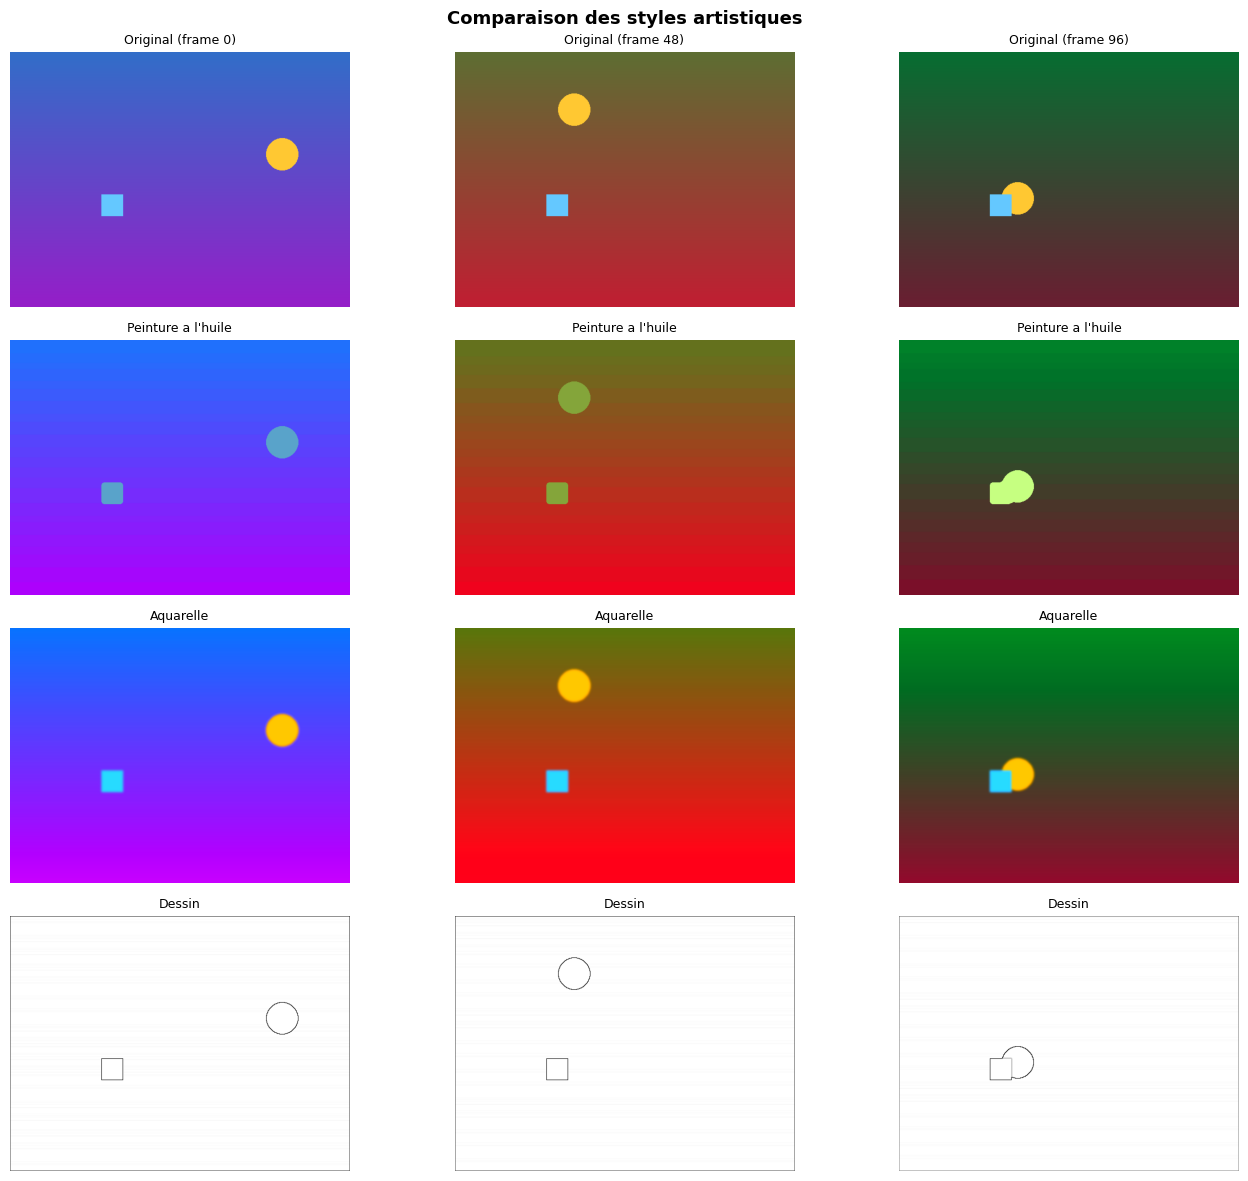


Generation video style 'aquarelle' (144 frames)...


Style applique en 2.35s (61 fps)


Video sauvegardee : creative_watercolor.mp4 (110 KB)


In [5]:
# Transfert de style video
if enable_style_transfer:
    print("\n--- TRANSFERT DE STYLE VIDEO ---")
    print("=" * 45)
    
    # Approche CPU : filtres artistiques avec Pillow
    def apply_oil_painting_effect(frame: np.ndarray, radius: int = 4) -> np.ndarray:
        """Simule un effet peinture a l'huile avec quantification des couleurs."""
        img = Image.fromarray(frame)
        # Reduire les details avec un flou
        img = img.filter(ImageFilter.MedianFilter(size=radius * 2 + 1))
        # Renforcer les contours
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(1.5)
        # Quantifier les couleurs pour l'effet peinture
        img = img.quantize(colors=24, method=Image.Quantize.MEDIANCUT)
        img = img.convert('RGB')
        return np.array(img)
    
    def apply_watercolor_effect(frame: np.ndarray) -> np.ndarray:
        """Simule un effet aquarelle avec flou et saturation."""
        img = Image.fromarray(frame)
        # Flou gaussien leger
        img = img.filter(ImageFilter.GaussianBlur(radius=2))
        # Augmenter la saturation
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(1.8)
        # Reduire la nettete
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(0.3)
        return np.array(img)
    
    def apply_sketch_effect(frame: np.ndarray) -> np.ndarray:
        """Simule un effet dessin au crayon avec detection de contours."""
        img = Image.fromarray(frame).convert('L')  # Niveaux de gris
        # Detection de contours
        edges = img.filter(ImageFilter.FIND_EDGES)
        # Inverser pour fond blanc, traits noirs
        edges = Image.eval(edges, lambda x: 255 - x)
        # Renforcer le contraste
        enhancer = ImageEnhance.Contrast(edges)
        edges = enhancer.enhance(2.0)
        return np.array(edges.convert('RGB'))
    
    # Appliquer les trois styles sur un echantillon de frames
    sample_indices = [0, n_frames // 3, 2 * n_frames // 3]
    styles = [
        ("Peinture a l'huile", apply_oil_painting_effect),
        ("Aquarelle", apply_watercolor_effect),
        ("Dessin", apply_sketch_effect),
    ]
    
    fig, axes = plt.subplots(len(styles) + 1, len(sample_indices), figsize=(14, 12))
    
    for col, idx in enumerate(sample_indices):
        # Original
        axes[0, col].imshow(source_frames[idx])
        axes[0, col].set_title(f"Original (frame {idx})", fontsize=9)
        axes[0, col].axis('off')
        
        # Styles
        for row, (style_name, style_fn) in enumerate(styles):
            styled = style_fn(source_frames[idx])
            axes[row + 1, col].imshow(styled)
            axes[row + 1, col].set_title(f"{style_name}", fontsize=9)
            axes[row + 1, col].axis('off')
    
    plt.suptitle("Comparaison des styles artistiques", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Generer une video complete avec un style
    print(f"\nGeneration video style 'aquarelle' ({len(source_frames)} frames)...")
    start_time = time.time()
    styled_frames = [apply_watercolor_effect(f) for f in source_frames]
    style_time = time.time() - start_time
    print(f"Style applique en {style_time:.2f}s ({len(source_frames) / style_time:.0f} fps)")
    
    if dependencies.get('imageio', False) and save_results:
        styled_path = OUTPUT_DIR / "creative_watercolor.mp4"
        writer = imageio.get_writer(str(styled_path), fps=video_fps, codec='libx264')
        for f in styled_frames:
            writer.append_data(f)
        writer.close()
        print(f"Video sauvegardee : {styled_path.name} ({styled_path.stat().st_size / 1024:.0f} KB)")
else:
    print("Transfert de style desactive")

### Interpretation : Transfert de style

| Style | Technique | Temps/frame | Usage ideal |
|-------|-----------|-------------|-------------|
| Peinture a l'huile | Filtre median + quantification | ~50ms | Clips courts artistiques |
| Aquarelle | Flou + saturation | ~20ms | Ambiances douces |
| Dessin | Detection de contours | ~10ms | Storyboards, tutoriels |

**Points cles** :
1. Les filtres Pillow sont rapides mais limites en qualite artistique
2. Pour un vrai transfert de style neuronal, utiliser diffusers img2img (GPU requis)
3. La coherence temporelle est un defi : chaque frame est traitee independamment

## Section 2 : Creation de clip musical

La creation d'un clip musical synchronise implique de detecter le rythme (BPM)
et de placer des coupes, effets et transitions sur les temps forts.
Ici, nous simulons un signal audio rythmique et synchronisons les effets video.


--- CREATION CLIP MUSICAL ---
BPM simule : 120
Intervalle entre beats : 0.500s
Nombre de beats : 12
Positions (frames) : [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132]


Effets appliques sur 12 beats


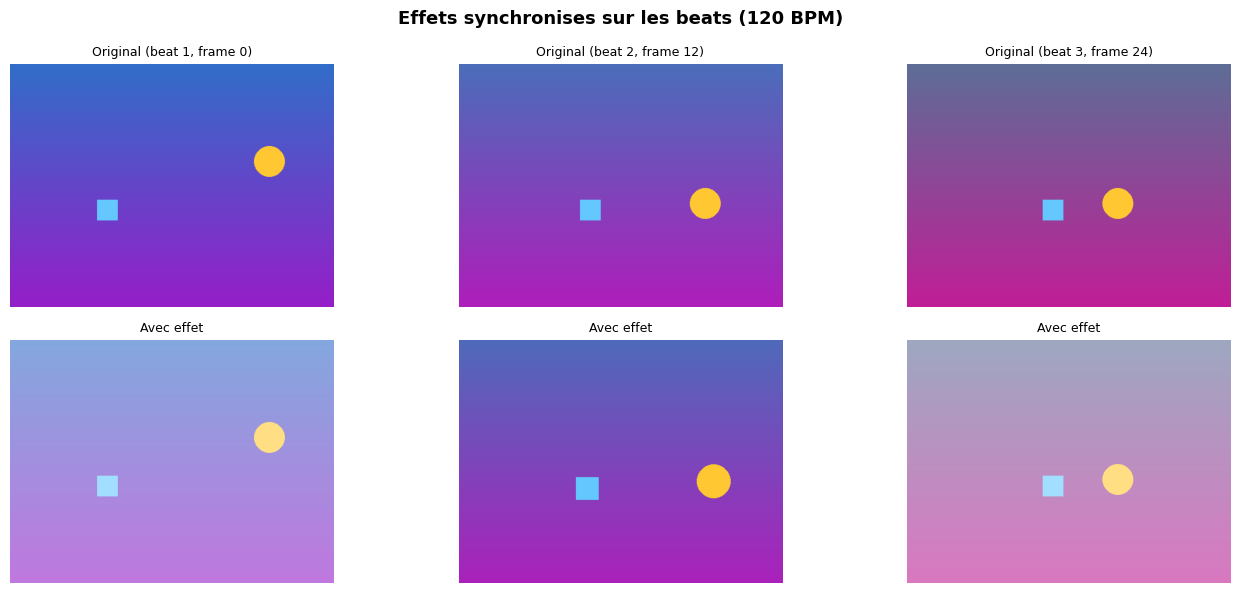

Video sauvegardee : creative_music_video.mp4 (113 KB)


In [6]:
# Creation de clip musical avec synchronisation
if enable_music_video:
    print("\n--- CREATION CLIP MUSICAL ---")
    print("=" * 40)
    
    # Simuler la detection de beats (BPM = 120)
    bpm = 120
    beat_interval = 60.0 / bpm  # Secondes entre chaque beat
    total_seconds = video_duration
    
    # Generer les positions des beats
    beat_times = np.arange(0, total_seconds, beat_interval)
    beat_frames = (beat_times * video_fps).astype(int)
    beat_frames = beat_frames[beat_frames < len(source_frames)]
    
    print(f"BPM simule : {bpm}")
    print(f"Intervalle entre beats : {beat_interval:.3f}s")
    print(f"Nombre de beats : {len(beat_frames)}")
    print(f"Positions (frames) : {beat_frames.tolist()}")
    
    # Effets synchronises sur les beats
    def apply_beat_flash(frame: np.ndarray, intensity: float = 0.5) -> np.ndarray:
        """Flash lumineux sur un beat."""
        flash = np.full_like(frame, 255)
        return np.clip(frame * (1 - intensity) + flash * intensity, 0, 255).astype(np.uint8)
    
    def apply_beat_zoom(frame: np.ndarray, zoom_factor: float = 1.15) -> np.ndarray:
        """Effet zoom leger sur un beat."""
        h, w = frame.shape[:2]
        img = Image.fromarray(frame)
        
        # Zoom au centre
        new_w = int(w * zoom_factor)
        new_h = int(h * zoom_factor)
        img_zoomed = img.resize((new_w, new_h), Image.LANCZOS)
        
        # Recadrer au centre
        left = (new_w - w) // 2
        top = (new_h - h) // 2
        img_cropped = img_zoomed.crop((left, top, left + w, top + h))
        
        return np.array(img_cropped)
    
    # Appliquer les effets avec decroissance
    music_frames = [f.copy() for f in source_frames]
    beat_decay_frames = 3  # Nombre de frames pour l'attenuation de l'effet
    
    for beat_frame in beat_frames:
        for offset in range(beat_decay_frames):
            idx = beat_frame + offset
            if idx >= len(music_frames):
                break
            decay = 1.0 - (offset / beat_decay_frames)
            # Alterner flash et zoom
            if (np.where(beat_frames == beat_frame)[0][0]) % 2 == 0:
                music_frames[idx] = apply_beat_flash(music_frames[idx], 0.4 * decay)
            else:
                zoom = 1.0 + 0.1 * decay
                music_frames[idx] = apply_beat_zoom(music_frames[idx], zoom)
    
    print(f"Effets appliques sur {len(beat_frames)} beats")
    
    # Visualiser quelques beats
    if len(beat_frames) >= 3:
        fig, axes = plt.subplots(2, 3, figsize=(14, 6))
        for col in range(3):
            b_idx = beat_frames[col]
            axes[0, col].imshow(source_frames[b_idx])
            axes[0, col].set_title(f"Original (beat {col+1}, frame {b_idx})", fontsize=9)
            axes[0, col].axis('off')
            axes[1, col].imshow(music_frames[b_idx])
            axes[1, col].set_title(f"Avec effet", fontsize=9)
            axes[1, col].axis('off')
        plt.suptitle(f"Effets synchronises sur les beats ({bpm} BPM)", fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    if dependencies.get('imageio', False) and save_results:
        music_path = OUTPUT_DIR / "creative_music_video.mp4"
        writer = imageio.get_writer(str(music_path), fps=video_fps, codec='libx264')
        for f in music_frames:
            writer.append_data(f)
        writer.close()
        print(f"Video sauvegardee : {music_path.name} ({music_path.stat().st_size / 1024:.0f} KB)")
else:
    print("Creation clip musical desactivee")

### Interpretation : Clip musical

| Aspect | Valeur | Signification |
|--------|--------|---------------|
| BPM | 120 | Rythme moyen (pop/dance) |
| Intervalle beats | 0.5s | Un beat toutes les 12 frames a 24fps |
| Effets | Flash + Zoom | Alternance pour varier le rythme visuel |
| Decay | 3 frames | Attenuation progressive de l'effet |

**Points cles** :
1. En production, le BPM serait detecte par analyse audio (librosa.beat)
2. L'attenuation progressive donne un rendu plus naturel que des effets instantanes
3. La synchronisation audio-video est critique : 1 frame de decalage est perceptible

## Section 3 : Effet stop-motion et color grading

L'effet stop-motion simule une animation image par image en reduisant le taux de frames
et en ajoutant des imperfections. Le color grading transforme l'ambiance de la video.


--- EFFET STOP-MOTION ---


Frames originales : 144
Frames stop-motion : 144
FPS effectif : 6 (maintien de 4 frames)

--- COLOR GRADING ---


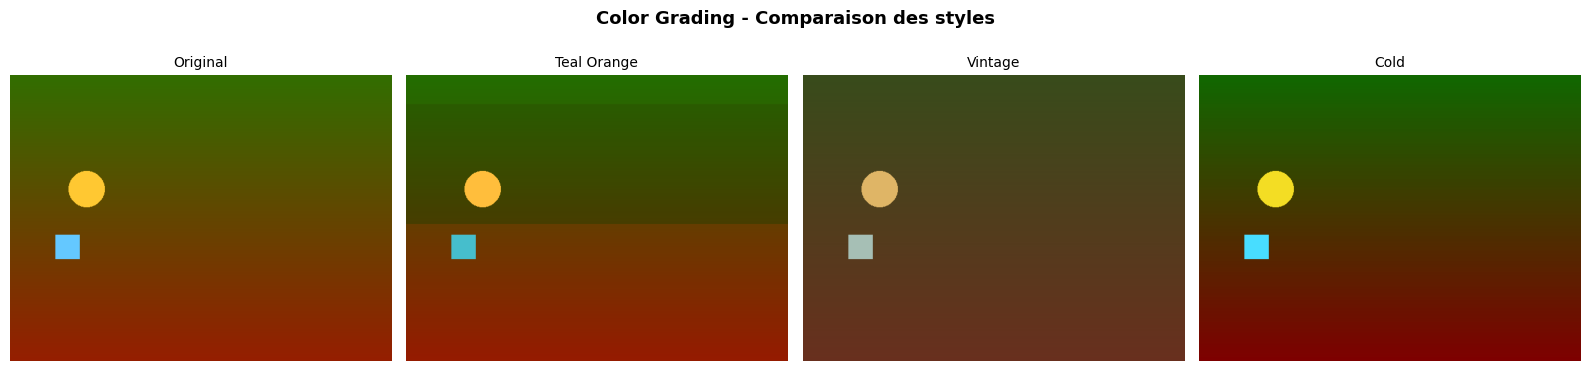

Styles disponibles : teal_orange, vintage, cold


In [7]:
# Effet stop-motion
if enable_stop_motion:
    print("\n--- EFFET STOP-MOTION ---")
    print("=" * 40)
    
    def create_stop_motion(frames: List[np.ndarray], hold_count: int = 4,
                           jitter: float = 2.0) -> List[np.ndarray]:
        """
        Cree un effet stop-motion : chaque frame est maintenue pendant N frames
        avec un leger decalage aleatoire pour simuler l'imprecision.
        
        Args:
            frames: Frames source
            hold_count: Nombre de frames a maintenir chaque image
            jitter: Amplitude du decalage aleatoire en pixels
        """
        result = []
        rng = np.random.RandomState(42)
        
        for i in range(0, len(frames), hold_count):
            base_frame = frames[i]
            
            for j in range(hold_count):
                if i + j >= len(frames):
                    break
                # Ajouter un leger jitter de position
                if jitter > 0:
                    dx = int(rng.uniform(-jitter, jitter))
                    dy = int(rng.uniform(-jitter, jitter))
                    img = Image.fromarray(base_frame)
                    shifted = Image.new('RGB', img.size, (0, 0, 0))
                    shifted.paste(img, (dx, dy))
                    result.append(np.array(shifted))
                else:
                    result.append(base_frame.copy())
        
        return result
    
    stop_frames = create_stop_motion(source_frames, hold_count=4, jitter=2.0)
    effective_fps = video_fps / 4
    
    print(f"Frames originales : {len(source_frames)}")
    print(f"Frames stop-motion : {len(stop_frames)}")
    print(f"FPS effectif : {effective_fps:.0f} (maintien de 4 frames)")

# Color grading cinematographique
if enable_color_grading:
    print("\n--- COLOR GRADING ---")
    print("=" * 40)
    
    def apply_color_grade(frame: np.ndarray, style: str = "teal_orange") -> np.ndarray:
        """
        Applique un color grading cinematographique.
        
        Styles : teal_orange (blockbuster), vintage (film ancien), cold (thriller)
        """
        img = frame.astype(np.float32) / 255.0
        
        if style == "teal_orange":
            # Tons chauds dans les hautes lumieres, froids dans les ombres
            shadows = img < 0.4
            highlights = img > 0.6
            result = img.copy()
            # Ombres : teinte bleu-vert
            result[:, :, 0] = np.where(shadows[:, :, 0], img[:, :, 0] * 0.7, img[:, :, 0])
            result[:, :, 1] = np.where(shadows[:, :, 1], img[:, :, 1] * 0.9, img[:, :, 1])
            result[:, :, 2] = np.where(shadows[:, :, 2], img[:, :, 2] * 1.2, img[:, :, 2])
            # Hautes lumieres : teinte orange
            result[:, :, 0] = np.where(highlights[:, :, 0], img[:, :, 0] * 1.2, result[:, :, 0])
            result[:, :, 1] = np.where(highlights[:, :, 1], img[:, :, 1] * 0.95, result[:, :, 1])
            result[:, :, 2] = np.where(highlights[:, :, 2], img[:, :, 2] * 0.8, result[:, :, 2])
        
        elif style == "vintage":
            # Desaturation + teinte sepia
            gray = np.mean(img, axis=2, keepdims=True)
            result = img * 0.4 + gray * 0.6  # Desaturation partielle
            result[:, :, 0] = result[:, :, 0] * 1.1  # Plus de rouge
            result[:, :, 1] = result[:, :, 1] * 1.0
            result[:, :, 2] = result[:, :, 2] * 0.85  # Moins de bleu
        
        elif style == "cold":
            # Tons froids, contraste eleve
            result = img.copy()
            result[:, :, 0] = img[:, :, 0] * 0.85  # Moins de rouge
            result[:, :, 2] = img[:, :, 2] * 1.15  # Plus de bleu
            # Augmenter le contraste
            result = (result - 0.5) * 1.3 + 0.5
        
        return (np.clip(result, 0, 1) * 255).astype(np.uint8)
    
    # Comparer les styles sur un echantillon
    sample_frame = source_frames[n_frames // 2]
    grade_styles = ["teal_orange", "vintage", "cold"]
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(sample_frame)
    axes[0].set_title("Original", fontsize=10)
    axes[0].axis('off')
    
    for i, style in enumerate(grade_styles):
        graded = apply_color_grade(sample_frame, style)
        axes[i + 1].imshow(graded)
        axes[i + 1].set_title(style.replace('_', ' ').title(), fontsize=10)
        axes[i + 1].axis('off')
    
    plt.suptitle("Color Grading - Comparaison des styles", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Styles disponibles : {', '.join(grade_styles)}")

### Interpretation : Stop-motion et color grading

| Technique | Parametres | Effet visuel |
|-----------|-----------|---------------|
| Stop-motion (hold=4) | 6 fps effectif | Saccade animee, look retro |
| Teal & Orange | Ombres bleutees, lumieres orange | Style blockbuster hollywoodien |
| Vintage | Desaturation + sepia | Effet film ancien, nostalgie |
| Cold | Bleus renforces, contraste eleve | Atmosphere thriller, tension |

**Points cles** :
1. Le stop-motion est obtenu en repetant chaque frame N fois (reduction du FPS effectif)
2. Le jitter (tremblements aleatoires) simule l'imprecision du positionnement manual
3. Le color grading professionnel utilise des LUTs (Look-Up Tables), ici simule par calcul

## Section 4 : Collages video et animations de texte

Les compositions video permettent d'afficher plusieurs flux simultanement.
Les animations de texte ajoutent un impact visuel pour les titres et generiques.


--- COLLAGE VIDEO ET ANIMATIONS ---
Generation des variantes pour la grille 2x2...


Grille generee : 144 frames
Resolution grille : 652x492


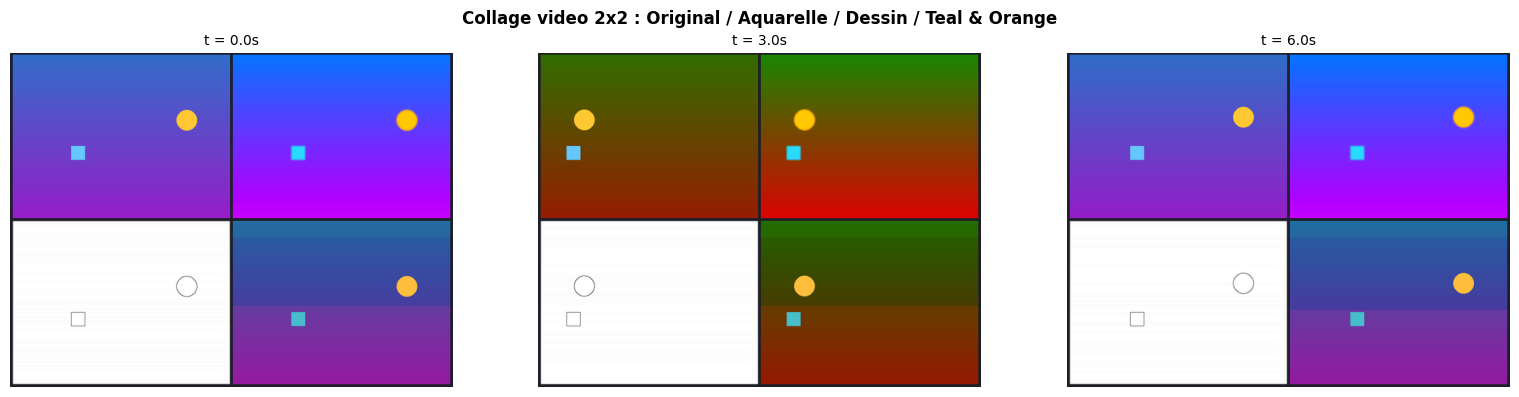

Video sauvegardee : creative_grid_collage.mp4 (208 KB)


In [8]:
# Collage video : grille 2x2 avec differents styles
print("\n--- COLLAGE VIDEO ET ANIMATIONS ---")
print("=" * 45)

def create_video_grid(frame_sets: List[List[np.ndarray]],
                      grid_size: Tuple[int, int] = (2, 2),
                      cell_size: Tuple[int, int] = (320, 240),
                      border: int = 4) -> List[np.ndarray]:
    """
    Cree une grille video a partir de plusieurs sequences de frames.
    
    Args:
        frame_sets: Liste de sequences de frames
        grid_size: (colonnes, lignes)
        cell_size: (largeur, hauteur) de chaque cellule
        border: Epaisseur des bordures en pixels
    """
    cols, rows = grid_size
    total_w = cols * cell_size[0] + (cols + 1) * border
    total_h = rows * cell_size[1] + (rows + 1) * border
    
    n_frames = min(len(fs) for fs in frame_sets)
    result = []
    
    for f_idx in range(n_frames):
        canvas = np.zeros((total_h, total_w, 3), dtype=np.uint8)
        canvas[:, :] = [30, 30, 40]  # Fond sombre
        
        for s_idx, frames in enumerate(frame_sets):
            if s_idx >= cols * rows:
                break
            row = s_idx // cols
            col = s_idx % cols
            
            x = border + col * (cell_size[0] + border)
            y = border + row * (cell_size[1] + border)
            
            # Redimensionner la frame
            img = Image.fromarray(frames[f_idx]).resize(cell_size, Image.LANCZOS)
            canvas[y:y + cell_size[1], x:x + cell_size[0]] = np.array(img)
        
        result.append(canvas)
    
    return result


# Generer les variantes pour la grille
print("Generation des variantes pour la grille 2x2...")
watercolor_frames = [apply_watercolor_effect(f) for f in source_frames]
sketch_frames = [apply_sketch_effect(f) for f in source_frames]
teal_frames = [apply_color_grade(f, 'teal_orange') for f in source_frames]

grid_frames = create_video_grid(
    [source_frames, watercolor_frames, sketch_frames, teal_frames],
    grid_size=(2, 2), cell_size=(320, 240), border=4
)

print(f"Grille generee : {len(grid_frames)} frames")
print(f"Resolution grille : {grid_frames[0].shape[1]}x{grid_frames[0].shape[0]}")

# Apercu
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
preview_idx = [0, len(grid_frames) // 2, len(grid_frames) - 1]
labels_grid = ["Original", "Aquarelle", "Dessin", "Teal & Orange"]
for i, ax in enumerate(axes):
    ax.imshow(grid_frames[preview_idx[i]])
    ax.set_title(f"t = {preview_idx[i] / video_fps:.1f}s", fontsize=10)
    ax.axis('off')
plt.suptitle("Collage video 2x2 : Original / Aquarelle / Dessin / Teal & Orange",
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

if dependencies.get('imageio', False) and save_results:
    grid_path = OUTPUT_DIR / "creative_grid_collage.mp4"
    writer = imageio.get_writer(str(grid_path), fps=video_fps, codec='libx264')
    for f in grid_frames:
        writer.append_data(f)
    writer.close()
    print(f"Video sauvegardee : {grid_path.name} ({grid_path.stat().st_size / 1024:.0f} KB)")


--- ANIMATIONS DE TEXTE ---


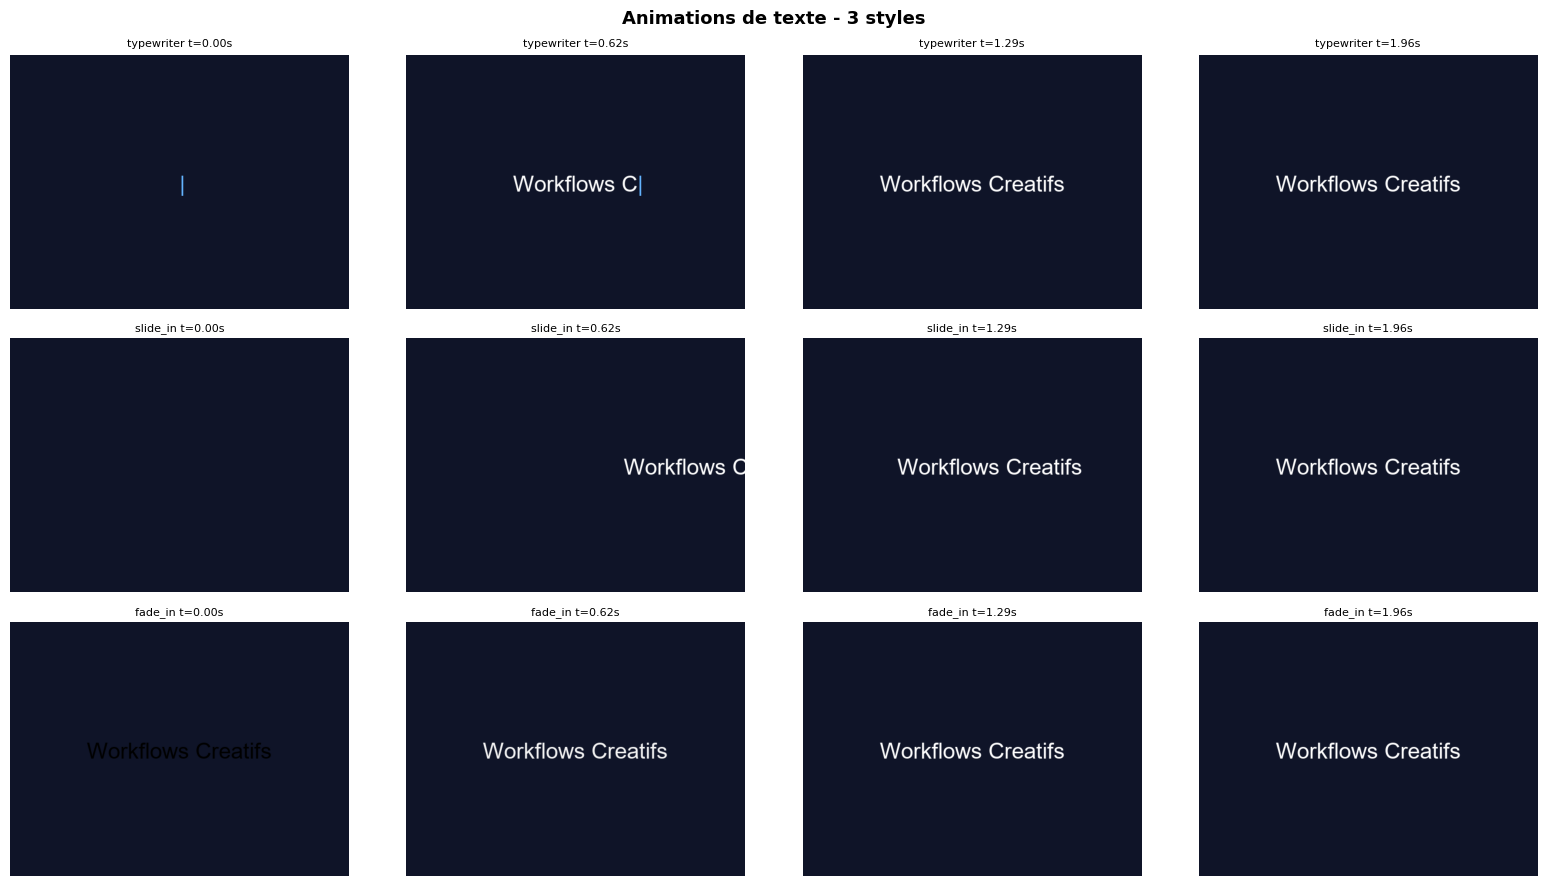

Styles d'animation disponibles : typewriter, slide_in, fade_in


In [9]:
# Animations de texte creatives
if enable_text_animation:
    print("\n--- ANIMATIONS DE TEXTE ---")
    print("=" * 40)
    
    def create_text_animation(text: str, width: int, height: int,
                              duration: float, fps: int,
                              style: str = "typewriter") -> List[np.ndarray]:
        """
        Cree une animation de texte.
        
        Styles : typewriter, slide_in, fade_in, scale_up
        """
        n_frames = int(duration * fps)
        frames = []
        
        try:
            font = ImageFont.truetype("arial.ttf", 42)
        except (OSError, IOError):
            font = ImageFont.load_default()
        
        for i in range(n_frames):
            t = i / max(n_frames - 1, 1)
            img = Image.new('RGB', (width, height), (15, 20, 40))
            draw = ImageDraw.Draw(img)
            
            if style == "typewriter":
                # Reveler caractere par caractere
                chars_visible = int(len(text) * min(t * 2, 1.0))
                visible_text = text[:chars_visible]
                bbox = draw.textbbox((0, 0), visible_text, font=font)
                tw = bbox[2] - bbox[0]
                draw.text(((width - tw) // 2, height // 2 - 20), visible_text,
                          fill=(255, 255, 255), font=font)
                # Curseur clignotant
                if chars_visible < len(text) and (i // (fps // 4)) % 2 == 0:
                    cursor_x = (width - tw) // 2 + tw
                    draw.text((cursor_x, height // 2 - 20), "|",
                              fill=(100, 180, 255), font=font)
            
            elif style == "slide_in":
                # Glissement depuis la droite
                bbox = draw.textbbox((0, 0), text, font=font)
                tw = bbox[2] - bbox[0]
                ease = 1 - (1 - t) ** 3  # Ease-out cubic
                x = int(width + tw - ease * (width + tw - (width - tw) // 2))
                draw.text((x, height // 2 - 20), text,
                          fill=(255, 255, 255), font=font)
            
            elif style == "fade_in":
                # Apparition progressive
                bbox = draw.textbbox((0, 0), text, font=font)
                tw = bbox[2] - bbox[0]
                alpha = min(t * 3, 1.0)
                color = tuple(int(255 * alpha) for _ in range(3))
                draw.text(((width - tw) // 2, height // 2 - 20), text,
                          fill=color, font=font)
            
            frames.append(np.array(img))
        
        return frames
    
    # Generer les trois styles
    text_demo = "Workflows Creatifs"
    anim_styles = ["typewriter", "slide_in", "fade_in"]
    
    fig, axes = plt.subplots(len(anim_styles), 4, figsize=(16, 9))
    
    for row, style in enumerate(anim_styles):
        anim_frames = create_text_animation(text_demo, video_width, video_height,
                                            2.0, video_fps, style)
        sample_idx = np.linspace(0, len(anim_frames) - 1, 4, dtype=int)
        for col, idx in enumerate(sample_idx):
            axes[row, col].imshow(anim_frames[idx])
            axes[row, col].set_title(f"{style} t={idx/video_fps:.2f}s", fontsize=8)
            axes[row, col].axis('off')
    
    plt.suptitle("Animations de texte - 3 styles", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Styles d'animation disponibles : {', '.join(anim_styles)}")
else:
    print("Animations de texte desactivees")

### Interpretation : Collages et animations

| Technique | Complexite | Usage |
|-----------|-----------|-------|
| Grille video 2x2 | Composition spatiale | Comparaisons cote a cote |
| Typewriter | Revelation progressive | Titres narratifs |
| Slide-in | Translation avec easing | Generiques, sous-titres |
| Fade-in | Opacite progressive | Transitions douces |

**Points cles** :
1. L'easing (ease-out cubic) rend les mouvements plus naturels que le lineaire
2. Les grilles video sont utiles pour les comparaisons avant/apres ou multi-styles
3. La combinaison de ces techniques produit des videos professionnelles

## Recapitulatif des techniques creatives

| Technique | Temps CPU | GPU requis | Difficulte |
|-----------|-----------|-----------|------------|
| Style transfer (filtres) | Rapide | Non | Facile |
| Style transfer (IA) | Lent | Oui (~16 GB) | Avance |
| Music video sync | Rapide | Non | Moyen |
| Stop-motion | Rapide | Non | Facile |
| Color grading | Rapide | Non | Moyen |
| Collage video | Moyen | Non | Facile |
| Animation texte | Rapide | Non | Moyen |

In [10]:
# Mode interactif - Choix du style
if notebook_mode == "interactive" and not skip_widgets:
    print("\n--- MODE INTERACTIF ---")
    print("=" * 40)
    print("Choisissez un style pour generer une video complete.")
    print("Styles : oil, watercolor, sketch, teal_orange, vintage, cold")
    print("(Laissez vide pour passer)")
    
    try:
        chosen_style = input("\nStyle (ou vide) : ").strip()
        
        if chosen_style:
            style_functions = {
                "oil": apply_oil_painting_effect,
                "watercolor": apply_watercolor_effect,
                "sketch": apply_sketch_effect,
            }
            grade_functions = {
                "teal_orange": lambda f: apply_color_grade(f, "teal_orange"),
                "vintage": lambda f: apply_color_grade(f, "vintage"),
                "cold": lambda f: apply_color_grade(f, "cold"),
            }
            all_functions = {**style_functions, **grade_functions}
            
            if chosen_style in all_functions:
                print(f"Application du style '{chosen_style}'...")
                custom_frames = [all_functions[chosen_style](f) for f in source_frames]
                print(f"Style applique sur {len(custom_frames)} frames")
            else:
                print(f"Style '{chosen_style}' non reconnu")
        else:
            print("Mode interactif ignore")
    
    except (KeyboardInterrupt, EOFError):
        print("Mode interactif interrompu")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type:
            print("Mode interactif non disponible (execution automatisee)")
        else:
            print(f"Erreur : {error_type}")
else:
    print("Mode batch - Interface interactive desactivee")

Mode batch - Interface interactive desactivee


In [11]:
# Statistiques de session
print("\n--- STATISTIQUES DE SESSION ---")
print("=" * 40)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Video source : {video_width}x{video_height} @ {video_fps}fps, {video_duration}s")
print(f"Frames source : {len(source_frames)}")

techniques_used = []
if enable_style_transfer: techniques_used.append("Style transfer")
if enable_music_video: techniques_used.append("Music video")
if enable_stop_motion: techniques_used.append("Stop-motion")
if enable_color_grading: techniques_used.append("Color grading")
if enable_text_animation: techniques_used.append("Text animation")
print(f"Techniques appliquees : {', '.join(techniques_used)}")

if save_results and OUTPUT_DIR.exists():
    generated_files = list(OUTPUT_DIR.glob('creative_*'))
    print(f"\nFichiers generes ({len(generated_files)}) :")
    for f in sorted(generated_files):
        size_kb = f.stat().st_size / 1024
        print(f"  {f.name} ({size_kb:.1f} KB)")

print(f"\nDependances utilisees :")
for dep, available in dependencies.items():
    status = "utilisee" if available else "non disponible"
    print(f"  {dep} : {status}")

print(f"\n--- PROCHAINES ETAPES ---")
print(f"1. Notebook 04-3 : Sora API - Generation Video Cloud")
print(f"2. Notebook 04-4 : Pipeline Video de Production (pipeline complet)")

print(f"\nNotebook 04-2 Creative Video Workflows termine - {datetime.now().strftime('%H:%M:%S')}")


--- STATISTIQUES DE SESSION ---
Date : 2026-02-19 10:31:08
Mode : batch
Video source : 640x480 @ 24fps, 6s
Frames source : 144
Techniques appliquees : Style transfer, Music video, Stop-motion, Color grading, Text animation

Fichiers generes (3) :
  creative_grid_collage.mp4 (207.6 KB)
  creative_music_video.mp4 (113.2 KB)
  creative_watercolor.mp4 (110.0 KB)

Dependances utilisees :
  moviepy : non disponible
  imageio : utilisee
  scipy : utilisee
  diffusers : utilisee

--- PROCHAINES ETAPES ---
1. Notebook 04-3 : Sora API - Generation Video Cloud
2. Notebook 04-4 : Pipeline Video de Production (pipeline complet)

Notebook 04-2 Creative Video Workflows termine - 10:31:08
